In [45]:
#| echo: false
import torch
import matplotlib.pyplot as plt

Course Page: <https://karpathy.ai/zero-to-hero.html>
{{< video https://www.youtube.com/watch?v=P6sfmUTpUmc >}}


# Parameter Initialization

Poor initialization of model weights can be problematic in at least two different cases:

## 1. Final Layer Bias Initilization
It can be common to see a "hockey stick" plot when analyzing the loss plots of a
neural network for the first few iterations of training. This happens when network is first
learning to scale the logits into the same range as the labels.

To mitigate this, the bias of the final layer can be set based on the type of ML task, and the
balance of the dataset used. For the example of Makemore, Andrej sets the bias to zero
to correspond to a uniform distribution. He could have also investigated the
distribution of letters in the dataset and set the bias according to that - this
is kind of like Empirical Bayes!

For other cases, Andrej provides advice in his [recipe for training neural nets](https://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines):

> * **init well.** Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.


## 2. Weight Initialization
Large values in matrices in pre-activation states can lead to strange behaviour
when passed through activation functions. For example, activation functions that
have asymptotic areas (tanh, sigmoid) can "saturate", leading to a high number
of outputs which are either 0 or 1. This can cause more problems in deep
networks. Ideally we want activations in the network to stay within the unit
Gaussian range - mean of 0, std of 1

We can fix this be initializing weights intelligently. In theory, this can be
done manually by scaling down randomly initialized weights, and inspecting the
effects on the distribution of activations. However this approach is not
scalable to larger networks.

Kaiming (AKA He) Initialization is a more principled way of doing this. It is
based on a mathematical analysis of the effects on the statistical changes made
by activation functions. 

This is functionally the same as what Andrej shows in the lecture - dividing the
unit normal weights by $gain * \sqrt{n_l}$, where
$n_l$ is the "fan-in", the number of inputs to the layer, and $gain$ is an
activation specific constant. These constants are defined [in pytorch too](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.calculate_gain):

| nonlinearity      | gain                                                                                |
|-------------------|-------------------------------------------------------------------------------------|
| Linear / Identity | 1                                                                                   |
| Conv{1,2,3}D      | 1                                                                                 |
| Sigmoid           | 1                                                                          |
| Tanh              | $\frac{5}{3}$​                                                                    |
| ReLU              | $\sqrt{2}$​                                                                         |
| Leaky Relu        | $\sqrt{\frac{2}{1 + \text{negative\_slope}^2}}$​​ |
| SELU              | $\frac{3}{4}$                                                                  |

The paper first describing this: [Delving Deep into Rectifiers: Surpassing
Human-Level Performance on ImageNet Classification - He, K. et al. (2015)
](https://arxiv.org/abs/1502.01852)

### Worked example

Let's imagine some neuron inputs `x` and neuron weights `w`. We can calculate the
matrix product `y` before passing the resulting values through an activation
function RELU to get some activations. When we compare the standard deviation in
`h` to `x` we can see there has been an increase.

tensor(0.9962) tensor(2.5542)


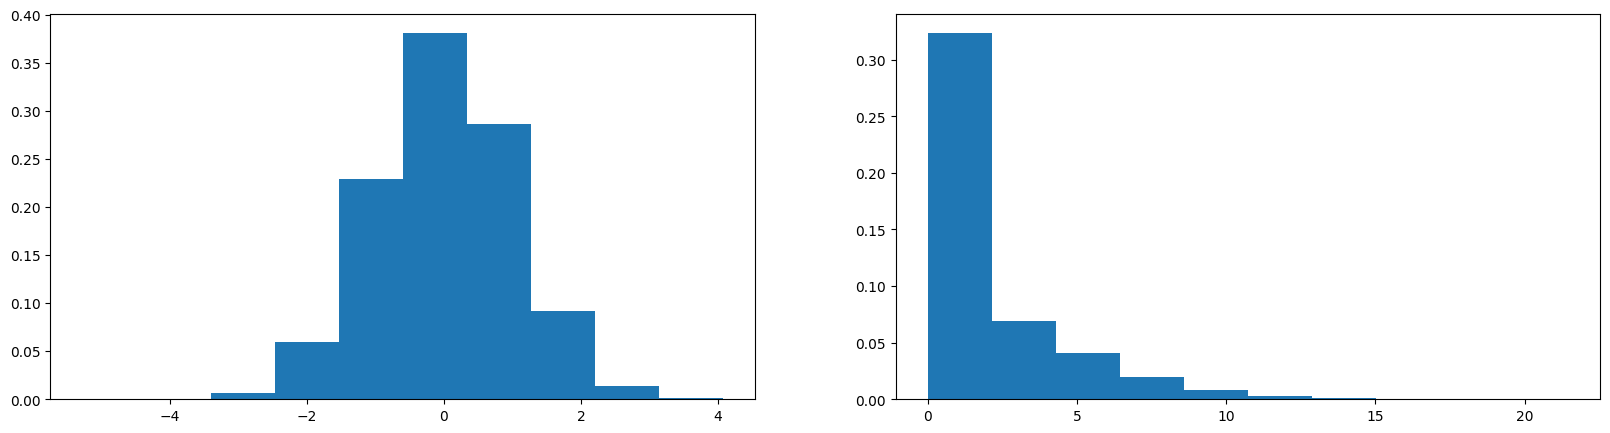

In [ ]:
x = torch.randn(1000, 20) # inputs
w = torch.randn(20, 200) # neuron weights
y = x @ w
h = torch.relu(y)


print(x.std(), h.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1), density=True);
plt.subplot(122)
plt.hist(h.view(-1), density=True);

`torch.randn` draws values from a unit normal distribution, $\mu=0, \sigma=1$ - so we can change
the standard deviation by scaling it by a factor. For RELU, our Kaiming
initialization should have $\sigma = \sqrt{\frac{2}{n_l}}$, where $n_l$ is the
"fan-in" - the number of inputs to the neuron

tensor(0.9962) tensor(0.8292)


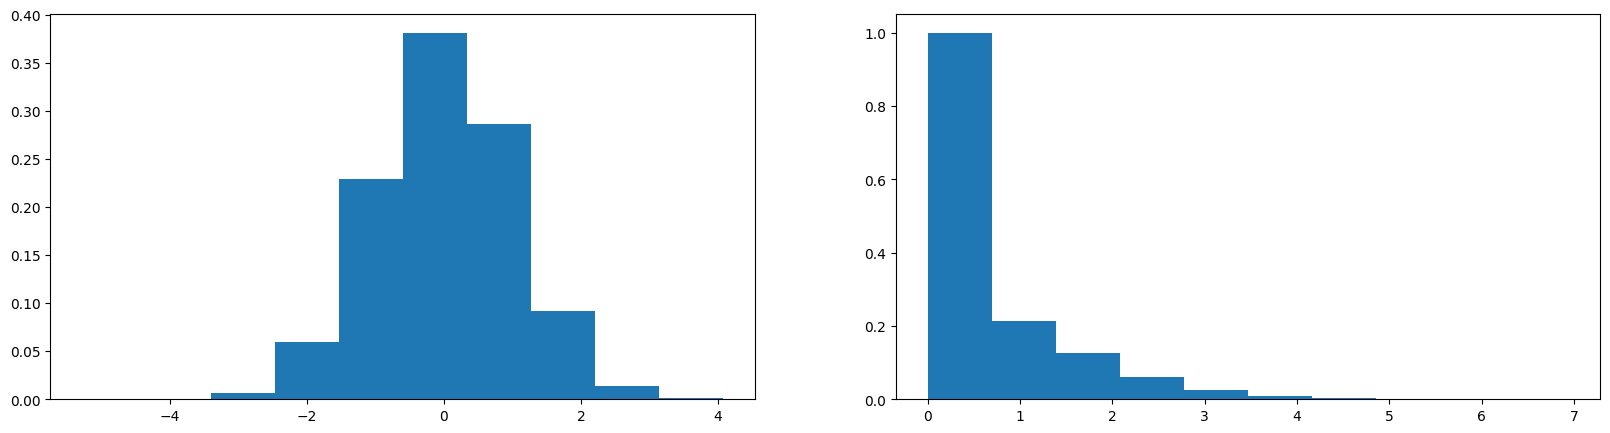

In [44]:
w = torch.randn(20, 200) * (2 / 20)**0.5 # init w with He Initialization
y = x @ w # x is fixed from above
h = torch.relu(y)

print(x.std(), h.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1), density=True);
plt.subplot(122)
plt.hist(h.view(-1), density=True);

We can see that this has reduced the standard deviation of the activations,
closer to the range of unit normal (although obviously the output of RELU is
not normally distributed)

::: {.callout-note collapse="true" title="NOTE: Default parameter initialization in `torch.nn.Linear`"}
When taking a look at the source code of `nn.Linear`, it might seem like they are
using the Kaiming init:

```python
def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
```

However from the comment it becomes clear that actually they are using the
`nn.init.kaiming_uniform_` function as a hack to achieve values from the uniform
distribution $U(-1/\sqrt(in\_features), 1/\sqrt(in\_features))$

To me it seems strange that they are not using an init defined in `nn.init` for
this...

Delving [into the pytorch forums](https://discuss.pytorch.org/t/how-are-layer-weights-and-biases-initialized-by-default/13073/33), it seems that this default init scheme is non standard:

> <div class="cooked"><p><a href="https://discuss.pytorch.org/t/whats-the-default-initialization-methods-for-layers/3157/17">One answer in this older thread</a> suggests that the initialisation resembles what is referred to “LeCun Initialisation”. This comment is probably long overdue, but pytorch does not implement LeCun <strong>or</strong> He/Kaiming initialisation for the <code>Linear</code> module.</p>
<p>If we go through the code (v1.5.0) of <code>Linear.reset_parameters</code>, the first line initialises the weight matrix:<br>
<code>init.kaiming_uniform_(self.weight, a=math.sqrt(5))</code>. If we take a look at how <code>kaiming_uniform</code> is implemented, we find that this line is equivalent to</p>
<pre><code class="hljs language-lua">fan = tensor.size(<span class="hljs-number">1</span>)  # fan-<span class="hljs-keyword">in</span> <span class="hljs-keyword">for</span> linear, as computed by _calculate_correct_fan
gain = <span class="hljs-built_in">math</span>.<span class="hljs-built_in">sqrt</span>(<span class="hljs-number">2.0</span> / (<span class="hljs-number">1</span> + a ** <span class="hljs-number">2</span>))  # gain, as computed by calculate_gain
std = gain / <span class="hljs-built_in">math</span>.<span class="hljs-built_in">sqrt</span>(fan)
bound = <span class="hljs-built_in">math</span>.<span class="hljs-built_in">sqrt</span>(<span class="hljs-number">3.0</span>) * std
with torch.no_grad():
    <span class="hljs-keyword">return</span> tensor.uniform_(-bound, bound)
</code></pre>
<p>Since <code>a = math.sqrt(5)</code> the weights are initialised with <code>std = 1 / math.sqrt(3.0 * fan_in)</code>. For reference, LeCun initialisation would be <code>1 / math.sqrt(fan_in)</code> and He initialisation uses <code>math.sqrt(2 / fan_in)</code>.</p>
<p>The bias initialisation in <code>Linear.reset_parameters</code> reveals another problem. Although biases are normally initialised with zeros (for the sake of simplicity), the idea is probably to initialise the biases with <code>std = math.sqrt(1 / fan_in)</code> (cf. LeCun init). By using this value for the boundaries of the uniform distribution, the resulting distribution has std <code>math.sqrt(1 / 3.0 * fan_in)</code>, which happens to be the same as the standard deviation for the weights.</p>
<p>A more reasonable default for me would be to use LeCun initialisation (since this has been the go-to standard since 1998). I could also understand Kaiming initialisation as the default, because everyone is using ReLU activation functions everywhere anyway (although I have a feeling that this is not necessarily the case for people working with fully connected networks). Some time ago, I submitted a <a href="https://github.com/pytorch/pytorch/pull/14034" rel="nofollow noopener">pull request</a> to adopt LeCun initialisation as the default, but there seems to be little incentive to actually make changes due to backward compatibility.</p>
<p>This probably also explains why pytorch ended up with its own initialisation strategy for fully connected networks. Someone must have forgotten about the fact that a uniform distribution with bounds <code>-b, b</code> has a standard deviation of <code>b / math.sqrt(3)</code> instead of just <code>b</code>. Due to backwards compatibility this got stuck and no-one is willing to make the change to the more widely accepted and standard initialisation.</p></div>
:::

## Bias Initialization
For biases not in the final layer, both Kaiming Initialization and other regimes
set the bias to 0

# Batch Normalization
This methodology was proposed in 2015 to address issues with the stability of
training deeper models.

In effect the idea is to calculate the mean and standard deviation of all inputs
across the batch, and use these to center and scale the inputs to unit normal. 

An additional two parameters $\gamma$ and $\beta$ are learned as part of the optimisation process,
and they restore the representation power of the network after the centering and
scaling 

$$ \mu = \frac{\sum_{i=1}^{n}x_i}{n} $$

$$ \sigma = \sqrt\frac{\sum_{i=1}^{n} (x_i - \mu)^2}{n}$$

$$ x_{scaled} = \frac{x_i - \mu}{\sigma + \epsilon} $$ 
(a very small epsilon value is used to avoid divide by zero issues)

$$ y_{out} = \gamma x_{scaled} + \beta$$

One problem with this approach is that it couples together all
samples within a batch when it comes to backpropagation. It can also
be the source of painful bugs when used in the wild.

Since then, numerous other methods have been proposed to try and address these
issues, eg. Layer Normalization

[Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." International conference on machine learning. pmlr, 2015.](https://arxiv.org/abs/1502.03167)

# Exercises

- E01: I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

When all weights and biases are set to zero, we can empirically see that there
is not much going on when we train the model. In fact, the only parameters that
seem to be changing are the final layer bias. We can reason about this by
thinking about the forward and backward passes when all parameters are
initialized to 0.


**Forward pass**

$y = Wx + b \rightarrow 0 * x + 0 = 0$

$tanh(y) = tanh(0) = 0$

Based on this, we know that the activation produced by each neuron will be 0.
This also means that all neurons inputs (except for the first layer) will also
be zero.

**Backward Pass**

Thinking about the backward pass, we can think about what the local derivatives
are for the final layer expression, to discover what is going on with the
gradients.

$y = Wx + b$

$\frac{\partial y}{\partial W} = x$

$\frac{\partial y}{\partial b} = 1$

Using the chain rule, we will be multiplying these local gradients by the global
gradients to get the gradient to update with. The kicker here is that
$\frac{\partial y}{\partial W} = x = 0$, as $x$ is the output of our previous
layer, which we have shown is $tanh(0) = 0$. This parameter will not be updated
from zero. This also means that no gradient
will flow through to the earlier layers in the network!

Additionally, as the local gradient wrt. the final layer bias = 1, this means
that this parameter will be updated from 0 as training progresses.

In [47]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]
len(words)
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [372]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
# layers = [
#   Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
# ]
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].bias *= 0 #0.1
  layers[-1].weight *= 0 #0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0 #1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [373]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []
wdist = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    # wdist.append([for l in layers])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2958


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


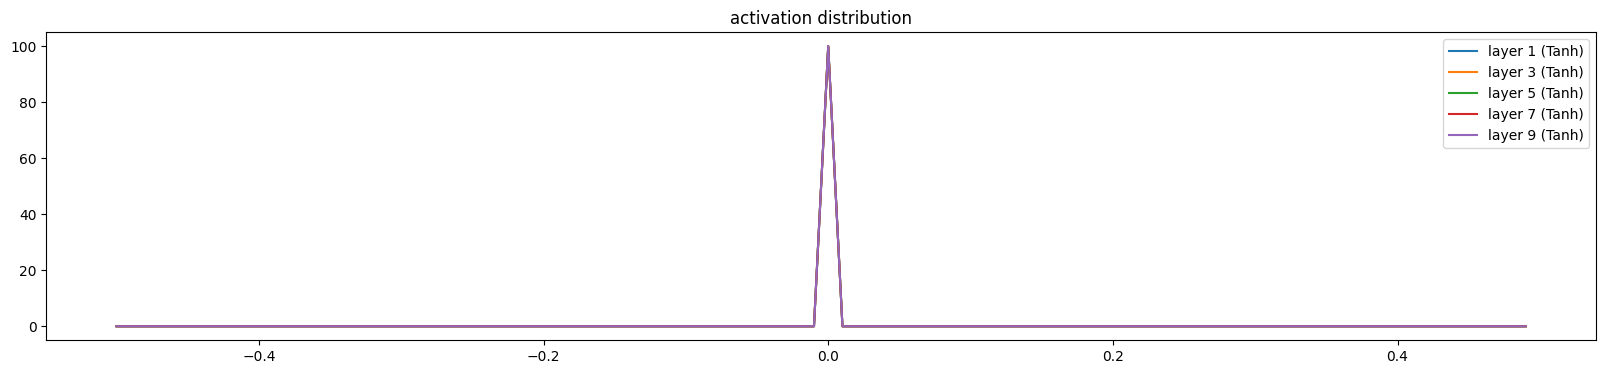

In [374]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution');

layer 0 (    Linear): mean +0.00, std 0.00
layer 2 (    Linear): mean +0.00, std 0.00
layer 4 (    Linear): mean +0.00, std 0.00
layer 6 (    Linear): mean +0.00, std 0.00
layer 8 (    Linear): mean +0.00, std 0.00
layer 10 (    Linear): mean +0.00, std 0.00


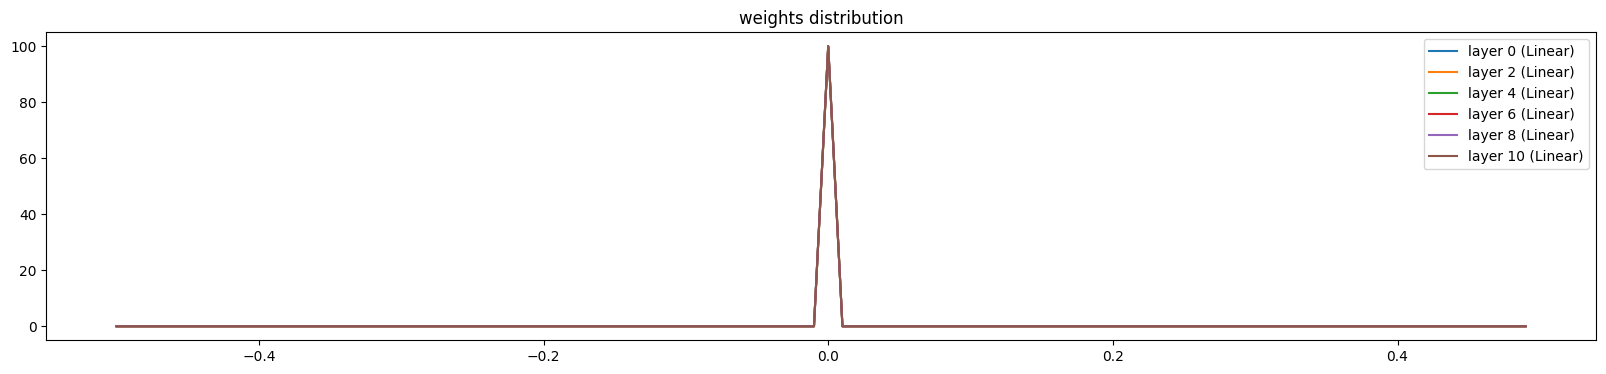

In [375]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): # note: exclude the output layer
  if isinstance(layer, Linear):
    t = layer.weight
    print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('weights distribution');

layer 0 (    Linear): mean +0.00, std 0.00
layer 2 (    Linear): mean +0.00, std 0.00
layer 4 (    Linear): mean +0.00, std 0.00
layer 6 (    Linear): mean +0.00, std 0.00
layer 8 (    Linear): mean +0.00, std 0.00
layer 10 (    Linear): mean -0.00, std 0.92


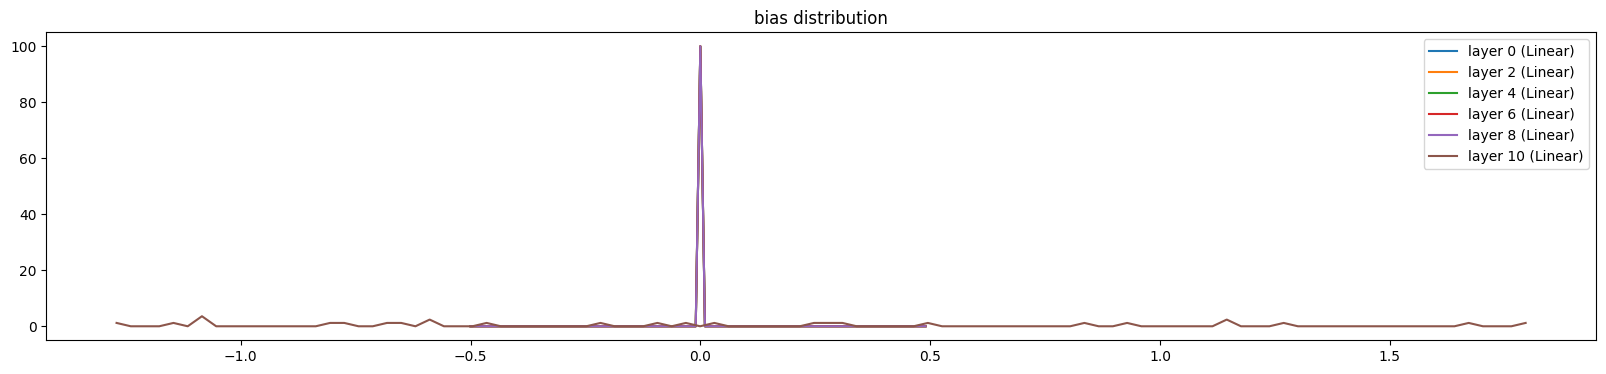

In [376]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers): 
  if isinstance(layer, Linear):
    t = layer.bias
    print('layer %d (%10s): mean %+.2f, std %.2f' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('bias distribution');

In [378]:
# we can see that this is the only parameter with non-zero values
layers[-1].bias

tensor([ 1.7014,  1.8266, -0.6536, -0.4635, -0.0927,  1.2793, -1.0680, -0.8004,
         0.2551,  1.1532, -0.5707, -0.1923,  0.9347,  0.0426,  1.1609,  0.3314,
        -1.0667, -1.2702,  0.8630,  0.2851, -0.0058, -0.5609, -0.6508, -1.0721,
        -1.1268,  0.5090, -0.7480], requires_grad=True)

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00
layer 9 (      Tanh): mean +0.000000, std 0.000000e+00


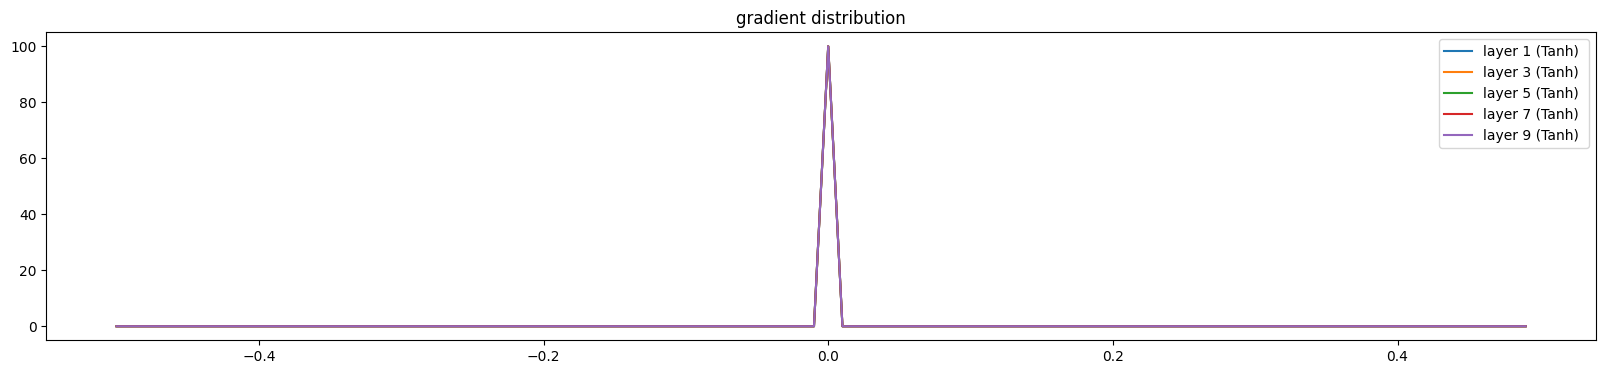

In [379]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach());
    legends.append(f'layer {i} ({layer.__class__.__name__}) ')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


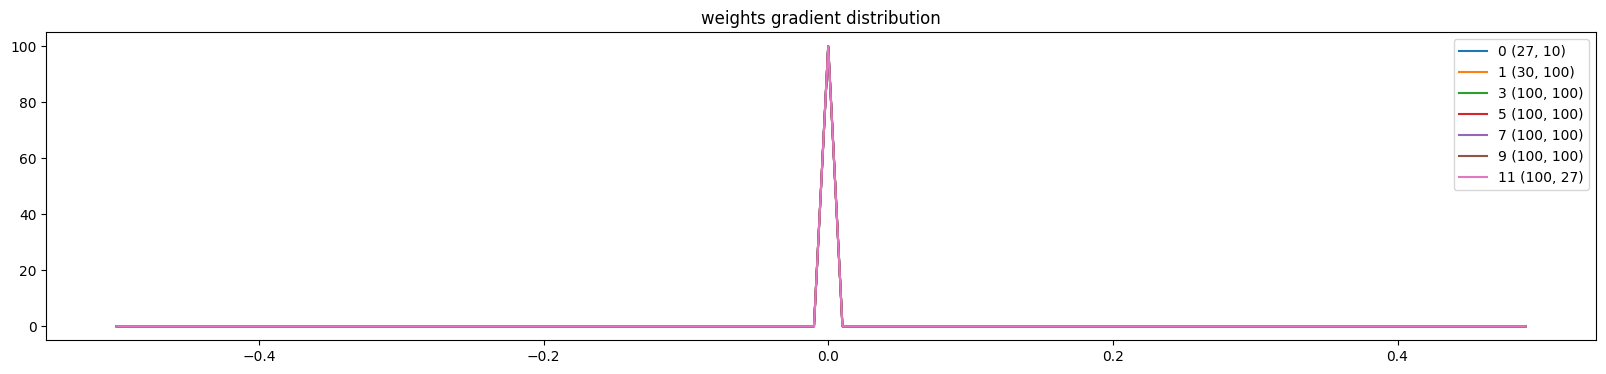

In [380]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

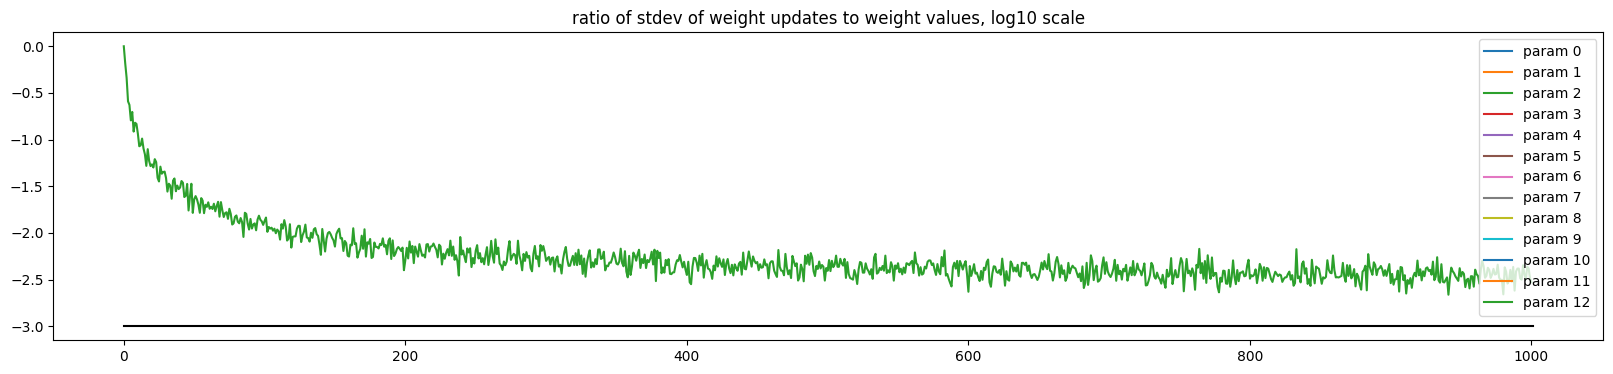

In [381]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  plt.plot([ud[j][i] for j in range(len(ud))])
  legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.title('ratio of stdev of weight updates to weight values, log10 scale');

We can also see that this bias is merely adopting the frequency distribution of
letters in the dataset 🤯

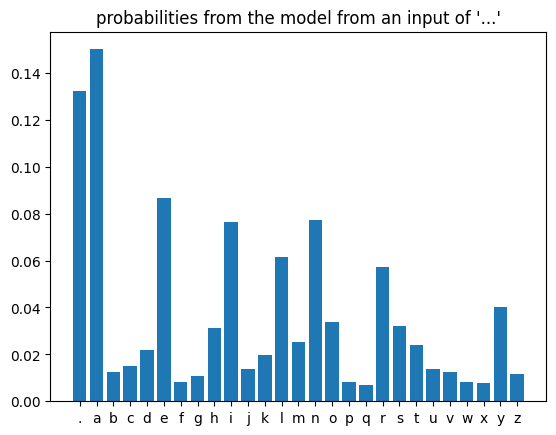

In [392]:
from string import ascii_lowercase

out = []
context = [0] * block_size

emb = C[torch.tensor([context])] # (1,block_size,n_embd)
x = emb.view(emb.shape[0], -1) # concatenate the vectors
for layer in layers:
    x = layer(x)
logits = x
probs = F.softmax(logits, dim=1)

letters_int = list(range(probs.shape[1]))

fig, ax = plt.subplots(1,1)
plt.bar(letters_int, probs.tolist()[0]);
ax.set_xticks(letters_int)
ax.set_xticklabels(["."] + list(ascii_lowercase))
plt.title("probabilities from the model from an input of '...'");

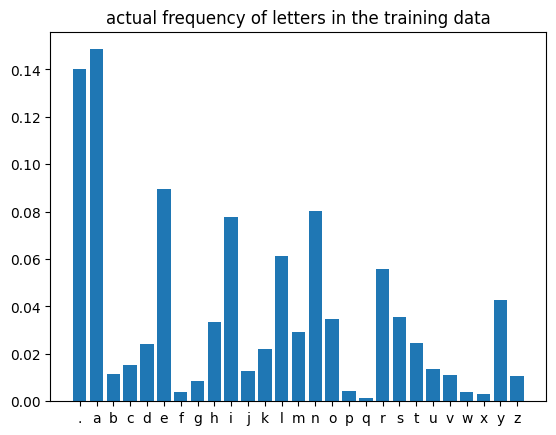

In [391]:
from collections import Counter

words_ending = [word + "." for word in words]
counts = Counter("".join(words_ending)) 
normed_counts = sorted([(k, v / len("".join(words_ending))) for k, v in counts.items()])

fig, ax = plt.subplots(1,1)
plt.bar(letters_int, [y for x, y in normed_counts]);
ax.set_xticks(letters_int)
ax.set_xticklabels(["."] + list(ascii_lowercase));
plt.title("actual frequency of letters in the training data");

The model also produces rubbish!

In [103]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ernaaimyazhseelmnd.
ryal.
.
etmrsjejdrleg.
adeeedieliihemy.
oealeieiseananarneltzimhlkaa.
n.
sadbvrgahimies.
.
n.
ir.
eelklxnteuofnu.
amnedar.
yidle.
ehs.
laajhysknyaa.
hya.
nalyaisun.
zajelveunen.
.


- E02: BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

First we can train the network with BatchNorm and run inference with it


In [364]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]

for p in parameters:
  p.requires_grad = True

In [365]:
# same optimization as last time
max_steps = 200000
batch_size = 32

for i in range(max_steps):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad
    
  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

In [366]:
# setting the batchnorm layers to inference mode is key! Otherwise we 
# overwrite the running mean and variance
for layer in layers:
  layer.training = False
  
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.


We can do some algebra to work out how to combine Linear and Batchnorm layers:

$y = Wx + b$

$y_{scaled} = \frac{y - \mu}{\sqrt{var + \epsilon}}$

$a = \gamma y_{scaled} + \beta$

$\therefore a = \gamma (\frac{Wx + b - \mu}{\sqrt{var + \epsilon}}) + \beta$

$\therefore W_{new} = \frac{\gamma W}{\sqrt{var + \epsilon}}, b_{new} = \gamma (\frac{b - \mu}{\sqrt{var + \epsilon}}) + \beta$

In [367]:
# now we combine each batchnorm layer with its prior linear layer
for i, layer in enumerate(layers):
    if i + 1 == len(layers):
        # skip last iteration
        break
    
    if isinstance(layer, Linear):
        bn = layers[i + 1]
        
        w = layer.weight
        b = layer.bias if layer.bias else 0
        
        layer.weight = bn.gamma * w / torch.sqrt(bn.running_var + bn.eps)
        layer.bias = bn.gamma * (b - bn.running_mean) / torch.sqrt(bn.running_var + bn.eps) + bn.beta

In [368]:
# remove the BatchNorm layers
layers = [layer for layer in layers if not isinstance(layer, BatchNorm1d)]

In [369]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mria.


We get the same output! 🔥